# Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling

In [ ]:
# Import all required libraries
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")
print("SpaCy model loaded successfully")

In [ ]:
# Load the SOTU data
sou = pd.read_csv("data/SOTU.csv")
print(f"Total speeches: {len(sou)}")
print(f"Columns: {sou.columns.tolist()}")
sou.head()

In [3]:
# Define preprocessing function
def preprocess_text(text): 
    doc = nlp(text) 
    return [token.lemma_.lower() for token in doc 
            if not token.is_stop and not token.is_punct and not token.is_space and len(token.lemma_) > 3]

# Process all texts - note this takes ~ 5 minutes to run
print("Processing documents... this will take about 5 minutes")
processed_docs = sou['Text'].apply(preprocess_text)
print(f"Processed {len(processed_docs)} documents")

Processing documents... this will take about 5 minutes
Processed 246 documents


## LDA Topic Modeling

In [4]:
# LDA using Gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Build dictionary and corpus
dictionary = Dictionary(processed_docs)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print(f"Dictionary size: {len(dictionary)}")
print(f"Corpus size: {len(corpus)}")

# Train LDA model with 18 topics
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=18,  # Required by assignment
    random_state=42,
    passes=10,
    alpha='auto',
    eta='auto'
)

# Print the top 10 words for each topic
print("\n--- LDA Topics ---")
for idx in range(18):
    print(f"\nTopic: {idx}")
    words = lda_model.show_topic(idx, 10)
    word_list = [word for word, prob in words]
    print(f"Words: {' + '.join(word_list)}")

Dictionary size: 7158
Corpus size: 246

--- LDA Topics ---

Topic: 0
Words: cent + june + gold + island + silver + bond + method + convention + indian + note

Topic: 1
Words: depression + program + recovery + budget + unemployment + loan + activity + farm + emergency + cent

Topic: 2
Words: dictator + expression + british + 1914 + impressive + actual + revolution + schedule + continent + partisanship

Topic: 3
Words: forest + corporation + judge + wrong + interstate + employee + bureau + body + mountain + island

Topic: 4
Words: program + soviet + 1980 + u.s. + area + major + goal + commitment + challenge + nuclear

Topic: 5
Words: americans + tonight + thank + today + budget + hard + program + worker + deficit + challenge

Topic: 6
Words: minister + british + intercourse + tribe + france + article + indians + spain + convention + deem

Topic: 7
Words: program + billion + budget + today + inflation + americans + percent + major + area + farm

Topic: 8
Words: method + railroad + confere

In [5]:
# Get topic distribution for the first speech
first_speech_bow = corpus[0]
topic_dist = lda_model[first_speech_bow]

print("Topic distribution for the first speech:")
print(f"Speech by: {sou.iloc[0]['President']} ({sou.iloc[0]['Year']})")
print("\nTopic probabilities:")
for topic_id, prob in sorted(topic_dist, key=lambda x: x[1], reverse=True):
    if prob > 0.01:  # Only show topics with >1% probability
        print(f"Topic {topic_id}: {prob:.4f}")

Topic distribution for the first speech:
Speech by: Joseph R. Biden (2024.0)

Topic probabilities:
Topic 11: 0.9996


In [6]:
# Visualize LDA model
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.124478 -0.021468       1        1  25.621139
6     -0.177732  0.042084       2        1  20.017284
5      0.215289  0.071402       3        1   9.900282
7      0.135458 -0.070126       4        1   9.764964
8     -0.048066 -0.119201       5        1   7.290226
17    -0.174399  0.056484       6        1   5.727512
13    -0.173280  0.057771       7        1   5.109096
9     -0.065558 -0.065626       8        1   3.666318
11     0.221104  0.096539       9        1   3.311493
12     0.108927 -0.107062      10        1   3.205471
4      0.170919 -0.059936      11        1   2.414235
3     -0.048272 -0.061103      12        1   1.958168
1      0.001860 -0.137763      13        1   1.022347
14     0.149902  0.117702      14        1   0.771223
15    -0.097783  0.071266      15        1   0.173085
2     -0.030784  0.033357      16        1   0.043723
16    -0.035439  0.047490      17        1   0.001744
10    -0.027669  0.048188      18        1   0.001691, topic_info=           Term         Freq        Total Category  logprob  loglift
509     program  1272.000000  1272.000000  Default  30.0000  30.0000
978      mexico   852.000000   852.000000  Default  29.0000  29.0000
31    americans   990.000000   990.000000  Default  28.0000  28.0000
5330    article   492.000000   492.000000  Default  27.0000  27.0000
666     tonight   666.000000   666.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
2624       cent     0.003161   614.018813  Topic18  -7.5314  -1.1891
5330    article     0.002930   492.377455  Topic18  -7.6071  -1.0441
66      billion     0.002999   600.252485  Topic18  -7.5841  -1.2192
1167     budget     0.003023   668.147797  Topic18  -7.5760  -1.3182
3190    british     0.002743   486.968210  Topic18  -7.6731  -1.0990

[1282 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
4847      4  0.881388  --the
4847      8  0.080126  --the
3170      1  0.132920   11th
3170      2  0.079752   11th
3170      6  0.292424   11th
...     ...       ...    ...
744       9  0.116606  young
744      10  0.003239  young
744      11  0.016195  young
744      12  0.009717  young
744      14  0.009717  young

[5616 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 6, 8, 9, 18, 14, 10, 12, 13, 5, 4, 2, 15, 16, 3, 17, 11])

## BERTopic Topic Modeling

In [8]:
# BERTopic Implementation
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Get raw documents
docs = sou['Text'].to_list()

# Train BERTopic model with min_topic_size=3
print("Training BERTopic model... this may take a few minutes")
topic_model = BERTopic(
    min_topic_size=3,
    verbose=False  # Removed random_state - not a valid parameter
)

topics, probs = topic_model.fit_transform(docs)
print(f"Number of topics found: {len(set(topics)) - 1}")  # -1 to exclude outlier topic

# Remove stop words from topics
vectorizer_model = CountVectorizer(stop_words="english")
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

Training BERTopic model... this may take a few minutes
Number of topics found: 15


In [9]:
# Display top 10 words for each BERTopic topic
topic_info = topic_model.get_topic_info()
print("BERTopic Topics (showing first 25):")
print(topic_info[['Topic', 'Count', 'Name']].head(25))

print("\n\nDetailed view of top 10 topics:")
for topic_num in topic_info['Topic'].head(10):
    if topic_num != -1:  # Skip outlier topic
        words = topic_model.get_topic(topic_num)
        word_list = [word for word, score in words[:10]]
        print(f"\nTopic {topic_num}: {', '.join(word_list)}")

BERTopic Topics (showing first 25):
    Topic  Count                                      Name
0      -1     49      -1_government_states_united_congress
1       0     89                0_world_america_new_people
2       1     17         1_states_united_government_public
3       2     14       2_states_government_united_congress
4       3     10            3_government_work_great_public
5       4     10               4_states_united_war_british
6       5      9            5_government_states_law_united
7       6      8          6_government_states_world_united
8       7      8    7_government_national_federal_congress
9       8      7       8_united_states_provision_gentlemen
10      9      6  9_states_government_country_constitution
11     10      5        10_states_government_congress_year
12     11      4  11_states_government_united_constitution
13     12      4        12_year_government_states_congress
14     13      3              13_states_people_shall_union
15     14      3    

In [10]:
# Get topic for the first speech
first_speech_topic = topics[0]
print(f"BERTopic assignment for first speech:")
print(f"Speech by: {sou.iloc[0]['President']} ({sou.iloc[0]['Year']})")
print(f"Assigned to Topic: {first_speech_topic}")

if first_speech_topic != -1:
    topic_words = topic_model.get_topic(first_speech_topic)
    print(f"Topic words: {[word for word, score in topic_words[:5]]}")

BERTopic assignment for first speech:
Speech by: Joseph R. Biden (2024.0)
Assigned to Topic: 0
Topic words: ['world', 'america', 'new', 'people', 'years']


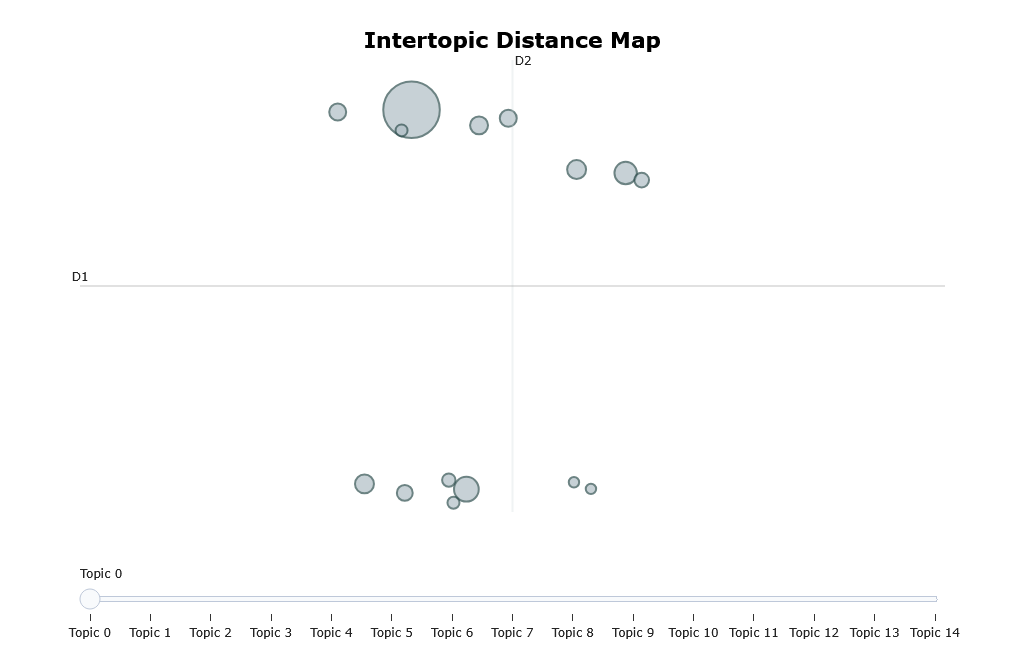

In [11]:
# Visualize BERTopic topics
topic_model.visualize_topics()

In [12]:
# Create outputs directory if it doesn't exist
import os
os.makedirs('outputs', exist_ok=True)
print("Results saved to outputs folder")

Results saved to outputs folder
